In [1]:
import os
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import networkx as nx
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold

from utils import plot_confusion_matrix, OneHotEncoder, clean_and_filter

print(tf.__version__)
print(tf.keras.__version__)

/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pasquale/opt/anaconda3/e

1.14.0
2.2.4-tf


Here we use a corpus of 438 MIDI files from [MuseData](http://old.musedata.org).

Those files refers to 139 classical music compositions, of which each file can represent a specific movement.

MuseData provides also some metadata, like the composer name, the scholar catalogue number, a label for the movement. 

Each composition is interlinked against the [DOREMUS knowledge base](http://data.doremus.org), a specialised music dataset dataset which gives access to the previously mentioned metadata and much more, such as the genre.

In [2]:
df = pd.read_csv('./musedata/musedata.csv', usecols = ['id', 'composer', 'genre', 'mvt', 'instrument'])
df

,mvt,genre,instrument,composer,id
0,Choral,cantata,O+V,Bach,bach-bg-cant-0001-midi1-01
1,Recitativo,cantata,O+V,Bach,bach-bg-cant-0001-midi1-02
2,Aria,cantata,O+V,Bach,bach-bg-cant-0001-midi1-03
3,Recitativo,cantata,O+V,Bach,bach-bg-cant-0001-midi1-04
4,Choral,cantata,O+V,Bach,bach-bg-cant-0001-midi1-06
...,...,...,...,...,...
433,Allegro,symphony,O,Mozart,mozart-bh-sym-k550-midi1-04
434,Allegro,symphony,O,Mozart,mozart-bh-sym-k551-midi1-01
435,Andante,symphony,O,Mozart,mozart-bh-sym-k551-midi1-02
436,Minuetto,symphony,O,Mozart,mozart-bh-sym-k551-midi1-03


We load the following kind of embeddings:
- midi2vec
- jSymbolic

In [8]:
emb = KeyedVectors.load_word2vec_format('./musedata/musedata.bin')

In [9]:
ids = df.id.tolist()
data = np.array([emb[i] for i in ids])

In [10]:
js_df = pd.read_csv('./musedata/musedata_jsymbolic.csv')
js_df

,Unnamed: 0,Basic_Pitch_Histogram_0,Basic_Pitch_Histogram_1,Basic_Pitch_Histogram_2,Basic_Pitch_Histogram_3,Basic_Pitch_Histogram_4,Basic_Pitch_Histogram_5,Basic_Pitch_Histogram_6,Basic_Pitch_Histogram_7,Basic_Pitch_Histogram_8,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04540,0.1804,0.25520,0.5190,0.001227,0.000000,0.0,0.000,0.00000,0.00000
1,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01818,0.1709,0.23270,0.5782,0.000000,0.003636,0.0,0.000,0.00000,0.00000
2,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.08216,0.1455,0.22180,0.5505,0.001174,0.000000,0.0,0.000,0.00000,0.00000
3,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04397,0.1319,0.13190,0.6922,0.000000,0.001629,0.0,0.000,0.00000,0.00000
4,/Users/pasquale/Dropbox/musedata/midi/bach-bg-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14570,0.3072,0.22870,0.3184,0.000000,0.026910,0.0,0.000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14200,0.2163,0.11330,0.5283,0.000771,0.069000,90.0,0.976,0.07558,0.01816
435,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.10110,0.2679,0.09344,0.5376,0.001586,0.049890,120.0,14.270,0.13230,0.02830
436,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.11340,0.1842,0.11740,0.5850,0.004660,0.054050,120.0,15.140,0.04367,0.01208
437,/Users/pasquale/Dropbox/musedata/midi/mozart-b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20960,0.1924,0.06883,0.5292,0.002251,0.092210,120.0,14.730,0.09983,0.03240


In [89]:
data_jsymbolic = []
names_jsymbolic = []
for i, x in js_df.iterrows():
    d = x.tolist()
    name = d[0].split('musedata/midi/')[1].replace('/', '-').rsplit('.', 1)[0]
    names_jsymbolic.append(name)
    data_jsymbolic.append([float(k) for k in d[1:]])
data_jsymbolic = np.array(data_jsymbolic)

In [90]:
data_jsymbolic = np.array([data_jsymbolic[names_jsymbolic.index(i)] for i in ids])
data_jsymbolic = np.nan_to_num(data_jsymbolic)

### Experiment 1: Genre

In DOREMUS, genres are very precise and go beyond the macro-genre "Classical"

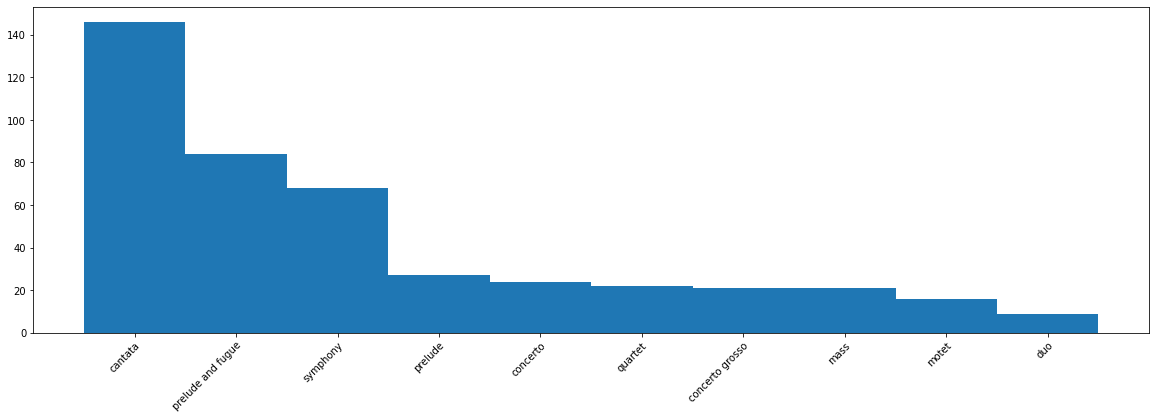

In [35]:
genres_filtered = clean_and_filter(data, df.genre, 0)

In [37]:
onehot = OneHotEncoder(df.genre.tolist())

onehot.get(onehot.labels[0])

'cantata'

In [38]:
onehot.labels.shape

(438, 10)

In [39]:
num_input = data.shape[1]
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 10)

In [40]:
def create_model(num_input, num_output):
    def m():
        model = tf.keras.Sequential()

        model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(num_output, activation='sigmoid'))

        model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

        return model
    return m

In [41]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=10, 
                                 batch_size=32,
                                 verbose=0)

In [11]:
random_state = 2111
scores = cross_val_score(neural_network, data, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre = np.mean(scores)
scores_genre

W0626 12:04:25.153306 4626324928 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0626 12:04:25.330546 4626324928 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[0.68181819 0.77272725 0.56818181 0.75       0.63636363 0.70454544
 0.75       0.75       0.79069769 0.72093022]


0.7125264227390289

In [47]:
np.std(scores)

0.06454544699877786

In [56]:
data_jsymbolic.shape

(438, 1495)

In [92]:
random_state = 2111
num_input = data_jsymbolic.shape[1]
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32,
                                 verbose=0)

scores = cross_val_score(neural_network, data_jsymbolic, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre_sym = np.mean(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.27272728 0.29545453 0.22727273 0.34090909 0.27272728 0.43181819
 0.52272725 0.36363637 0.25581396 0.3488372 ]
Accuracy: 0.333 (0.085)


In [93]:
from sklearn import svm
clf = svm.SVC()
scores = cross_val_score(clf, data_jsymbolic, df.genre,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre_sym = np.mean(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.27272727 0.38636364 0.27272727 0.38636364 0.31818182 0.45454545
 0.59090909 0.36363636 0.30232558 0.44186047]
Accuracy: 0.379 (0.093)


In [12]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

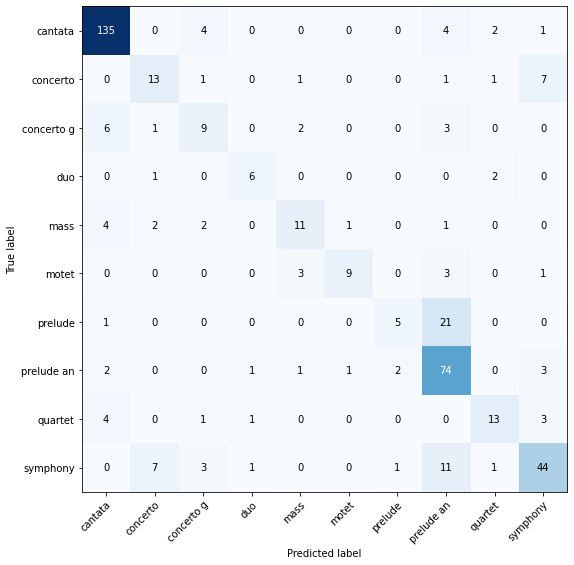

In [13]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre, title='musedata_genre')

#### Normalized confusion matrix

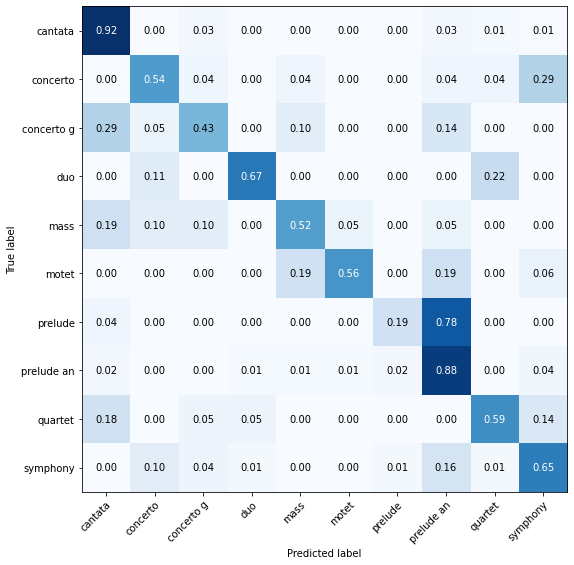

In [14]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre, normalize=True, title='musedata_genre')

### Experiment 1b: Genres (Split)

We perform a new experiment using the train/test split at embedding time

In [94]:
emb_x = [KeyedVectors.load_word2vec_format(f'./musedata/musedata{i}.bin') for i in range(10)]

In [97]:
ids[0]

'bach-bg-cant-0001-midi1-01'

In [102]:
data_x = []
for j in range(10):
    cur = emb_x[j]
    train_index = [i.replace('-midi1-', '-') for i in ids if i.replace('-midi1-', '-') in cur]
    train_index_mod = [i for i in ids if i.replace('-midi1-', '-') in cur]
    test_index = [i.replace('-midi1-', '-') for i in ids if i.replace('-midi1-', '-') not in cur]
    test_index_mod = [i for i in ids if i.replace('-midi1-', '-') not in cur]
    
    trX = cur[train_index]
    trY = df[df.id.isin(train_index_mod)]
    
    edg_folder = f'./musedata/edgelist{j}_test'
    edgelists = [qf for qf in os.listdir(edg_folder)
                 if qf.endswith('.edgelist') and not qf.startswith('_')]
    
    g = None
    for eg in edgelists:
        h = nx.read_edgelist(os.path.join(edg_folder, eg), nodetype=str, create_using=nx.DiGraph(), delimiter=' ')
        for edge in h.edges():
            h[edge[0]][edge[1]]['weight'] = 1

        g = h if g is None else nx.compose(g, h)

    g = g.to_undirected()

    teX = []
    for x in test_index:
        connections = [e[1] for e in list(g.edges(x))]
        vecs = np.array([(emb_x[j][e], 0.4 if e.startswith('g') else (0.2 if not e.startswith('http') else 1))
                         for e in connections if e in emb_x[j]])
        vec = np.average(vecs[:,0], weights=vecs[:,1], axis=0)
        teX.append(vec)
    teY = df[df.id.isin(test_index_mod)]

    data_x.append((trX,trY,teX,teY))

/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [104]:
num_input = data.shape[1]
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32,
                                 verbose=0)

In [105]:
random_state = 2111
scores_5cs = []

t_stat_s ={}
for j in range(10):
    trainX, trainY, testX, testY = data_x[j]
    oh = OneHotEncoder(trainY.genre.tolist()) 

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY = oh.encoder.transform(testY.genre.tolist()) 
    accuracy = neural_network.score(testX, testY, verbose=0)

    scores_5cs.append(accuracy)

print(scores_5cs)
m = np.mean(scores_5cs)
s = np.std(scores_5cs)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.3265306, 0.4732143, 0.5, 0.5641026, 0.84615386, 0.8333333, 0.6923077, 0.6666667, 0.4, 0.5]
Accuracy: 0.580 (0.166)


### Experiment 2: Composer

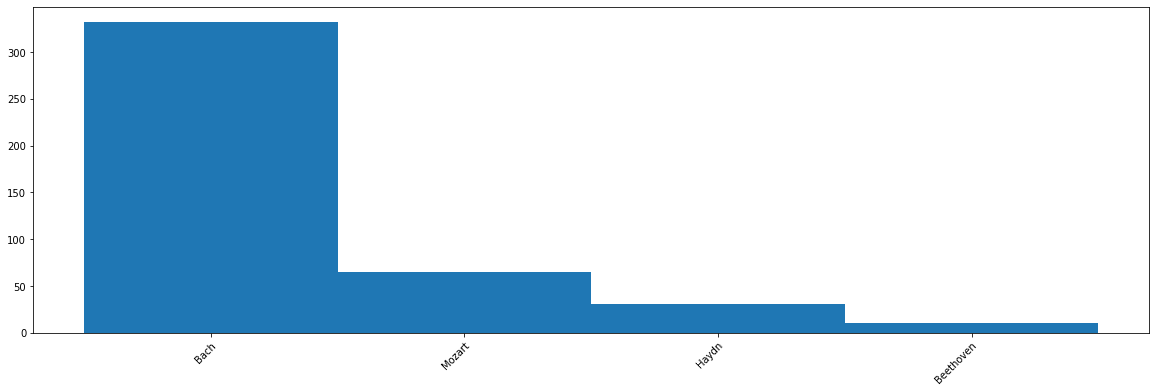

In [108]:
composer_filtered = clean_and_filter(data, df.composer, 0)

In [109]:
onehot = OneHotEncoder(df.composer)

num_output = onehot.labels.shape[1]
num_output

4

In [110]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose = 0)

In [18]:
random_state = 2111
scores = cross_val_score(neural_network, data, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_composer = np.mean(scores)
scores_composer

[0.93181819 0.77272725 0.95454544 0.97727275 0.95454544 0.90909094
 0.90909094 0.88636363 0.83720928 0.90697676]


0.9039640605449677

In [59]:
np.std(scores)

0.05772147853212873

In [111]:
random_state = 2111
num_input = data_jsymbolic.shape[1]
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32,
                                 verbose=0)

scores = cross_val_score(neural_network, data_jsymbolic, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre_sym = np.mean(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.75       0.68181819 0.75       0.84090906 0.81818181 0.77272725
 0.77272725 0.77272725 0.69767439 0.72093022]
Accuracy: 0.758 (0.047)


In [116]:
from sklearn import svm
clf = svm.SVC()
scores = cross_val_score(clf, data_jsymbolic, df.composer,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre_sym = np.mean(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.77272727 0.79545455 0.72727273 0.86363636 0.84090909 0.75
 0.84090909 0.81818182 0.74418605 0.72093023]
Accuracy: 0.787 (0.049)


In [19]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

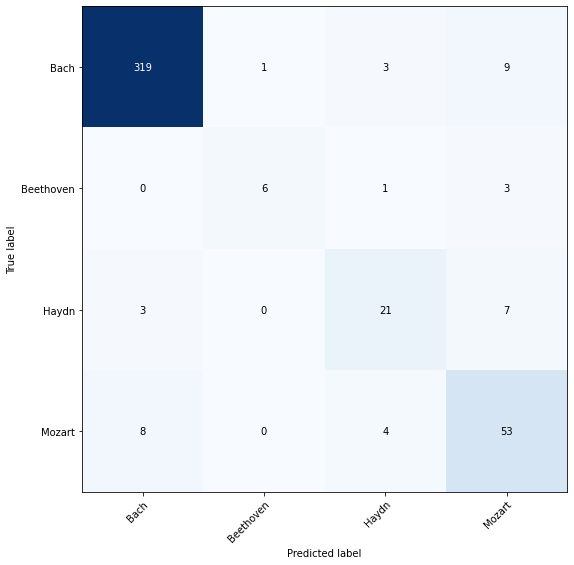

In [20]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.composer, title='musedata_composer')

#### Normalized confusion matrix

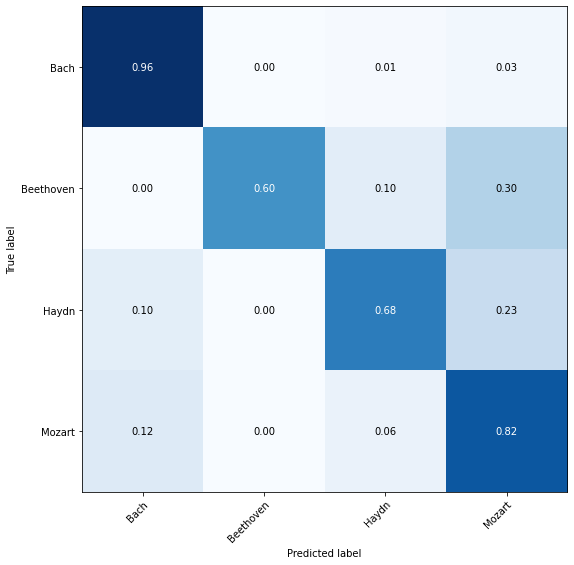

In [21]:
plot_confusion_matrix(onehot.labels, predicted, df.composer, normalize=True, title='musedata_composer')

### Experiment 2b: Composer (Split)

In [121]:
num_input = data.shape[1]
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32,
                                 verbose=0)

In [123]:
random_state = 2111
scores_5cs = []

t_stat_s ={}
for j in range(10):
    trainX, trainY, testX, testY = data_x[j]
    oh = OneHotEncoder(trainY.composer.tolist()) 

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY = oh.encoder.transform(testY.composer.tolist()) 
    accuracy = neural_network.score(testX, testY, verbose=0)

    scores_5cs.append(accuracy)

print(scores_5cs)
m = np.mean(scores_5cs)
s = np.std(scores_5cs)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.8367347, 0.7410714, 0.5645161, 0.74358976, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy: 0.889 (0.150)


### Experiment 3: Movement

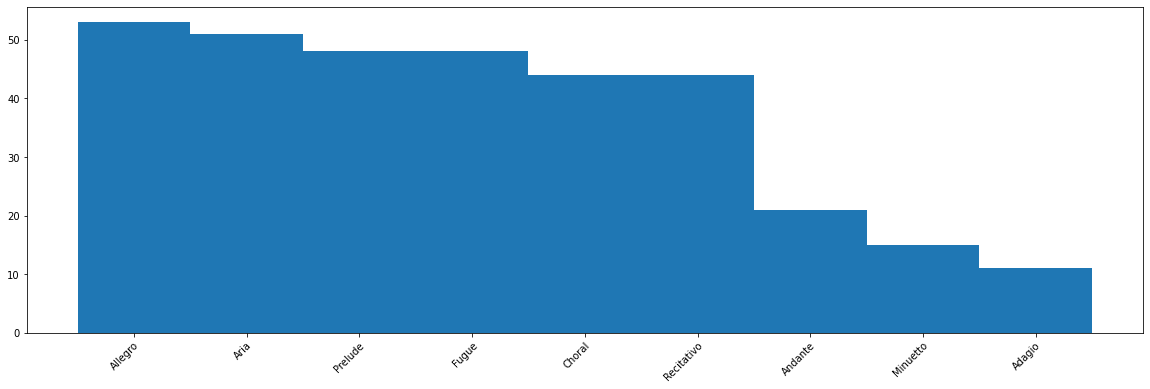

Distinct movement tag considered:


9

In [124]:
data_filtered, mvt_filtered = clean_and_filter(data, df.mvt, min_count=9)
print('Distinct movement tag considered:')
len(np.unique(mvt_filtered))

In [125]:
onehot = OneHotEncoder(mvt_filtered)

num_output = onehot.labels.shape[1]
num_output

9

In [126]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=10, 
                                 batch_size=32, verbose=0)

In [47]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_mvt = np.mean(scores)
scores_mvt

[0.91176468 0.67647058 0.55882353 0.67647058 0.7352941  0.75757575
 0.81818181 0.5151515  0.4848485  0.69696969]


0.683155071735382

In [127]:
np.std(scores)

0.12729521828251403

In [130]:
clf = svm.SVC()
scores = cross_val_score(clf, data_jsymbolic, df.mvt,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre_sym = np.mean(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.22727273 0.43181818 0.27272727 0.40909091 0.36363636 0.29545455
 0.34090909 0.36363636 0.23255814 0.30232558]
Accuracy: 0.324 (0.066)


In [26]:
predicted = cross_val_predict(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

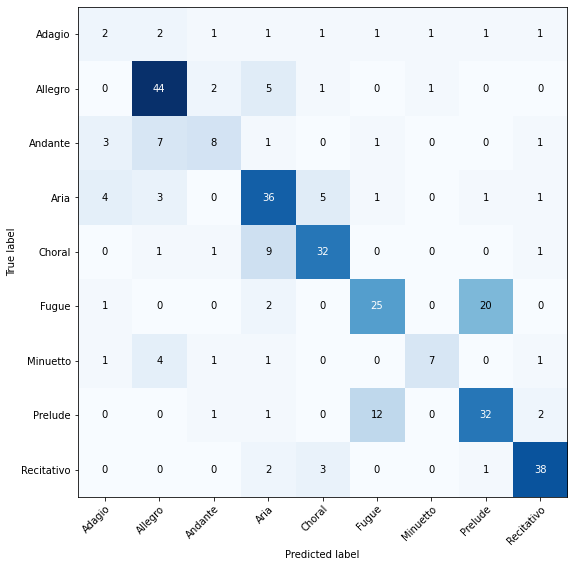

In [27]:
plot_confusion_matrix(onehot.labels, predicted, classes=mvt_filtered, title='musedata_mvt')

#### Normalized confusion matrix

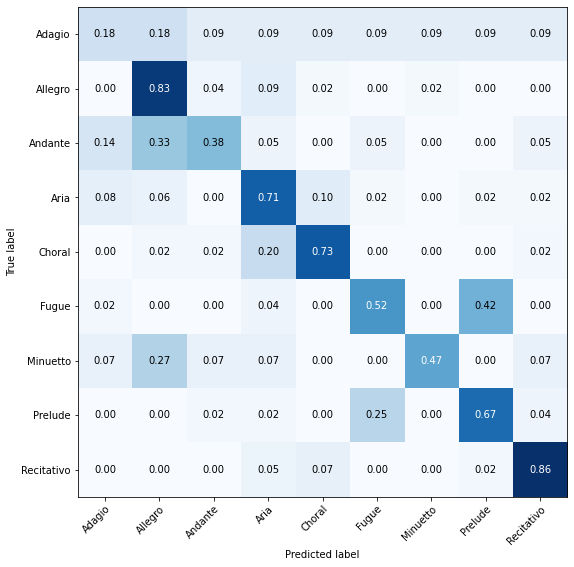

In [28]:
plot_confusion_matrix(onehot.labels, predicted, classes=mvt_filtered, normalize=True, title='musedata_mvt')

### Experiment 3b: Movement (Split)

In [174]:
data_x_filtered = []
for trainX, trainY, testX, testY in data_x:
    data_filtered, mvt_filtered = clean_and_filter(trainX, trainY.mvt, min_count=7, plotting=False)
    test_idx = testY.mvt.isin(np.unique(mvt_filtered))
    testY = testY[test_idx]
    test_idx = test_idx.to_list()
    testX = [x for i,x in enumerate(testX) if test_idx[i]]
    data_x_filtered.append((data_filtered, mvt_filtered, testX, testY))
    print('Distinct movement tag considered:', len(np.unique(mvt_filtered)))
    print(len(data_filtered), len(mvt_filtered), len(testX) , len(testY))

Distinct movement tag considered: 9
237 237 98 98
Distinct movement tag considered: 9
233 233 102 102
Distinct movement tag considered: 9
286 286 49 49
Distinct movement tag considered: 10
313 313 30 30
Distinct movement tag considered: 9
315 315 20 20
Distinct movement tag considered: 9
316 316 19 19
Distinct movement tag considered: 10
333 333 10 10
Distinct movement tag considered: 10
340 340 3 3
Distinct movement tag considered: 10
342 342 1 1
Distinct movement tag considered: 10
340 340 3 3


In [175]:
num_input = data.shape[1]

random_state = 2111
scores_5cs = []

t_stat_s ={}
for j in range(10):
    trainX, trainY, testX, testY = data_x_filtered[j]
    oh = OneHotEncoder(trainY)
    num_output = oh.labels.shape[1]

    neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose=0)
    

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY = oh.encoder.transform(testY.mvt.tolist()) 
    accuracy = neural_network.score(testX, testY, verbose=0)

    scores_5cs.append(accuracy)

print(scores_5cs)
m = np.mean(scores_5cs)
s = np.std(scores_5cs)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.33673468, 0.4019608, 0.3469388, 0.36666667, 0.5, 0.84210527, 0.7, 0.33333334, 1.0, 0.6666667]
Accuracy: 0.549 (0.227)


### Experiment 4: Instrument

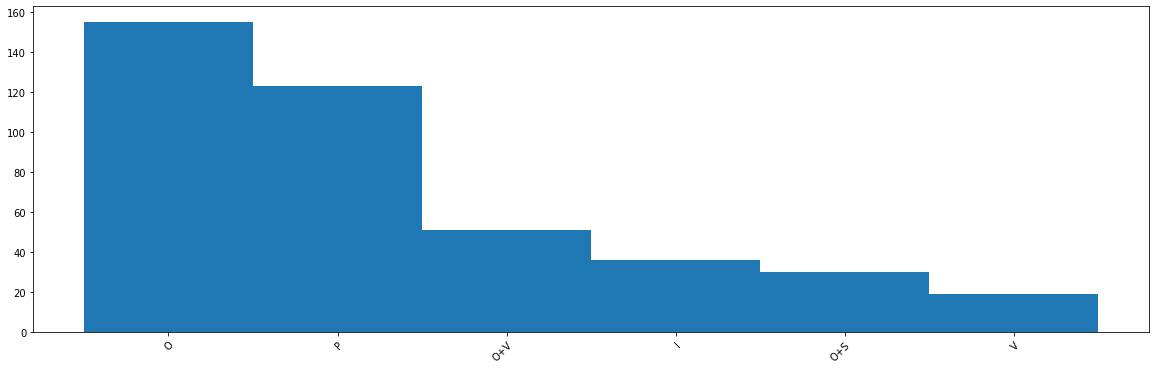

Distinct instrument considered:


6

In [176]:
data_filtered, instrument_filtered = clean_and_filter(data, df.instrument, min_count=9)
print('Distinct instrument considered:')
len(np.unique(instrument_filtered))

In [177]:
onehot = OneHotEncoder(instrument_filtered)

num_output = onehot.labels.shape[1]
num_output

6

In [178]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

In [32]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_instrument = np.mean(scores)
scores_instrument

[0.69047618 0.73809522 0.66666669 0.83333331 0.68292683 0.68292683
 0.65853661 0.14634146 0.70731705 0.70731705]


0.6513937249779701

In [179]:
np.std(scores)

0.17485770922143304

In [181]:
clf = svm.SVC()
scores = cross_val_score(clf, data_jsymbolic, df.instrument,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre_sym = np.mean(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.43181818 0.45454545 0.63636364 0.45454545 0.45454545 0.31818182
 0.34090909 0.52272727 0.48837209 0.51162791]
Accuracy: 0.461 (0.086)


In [33]:
predicted = cross_val_predict(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

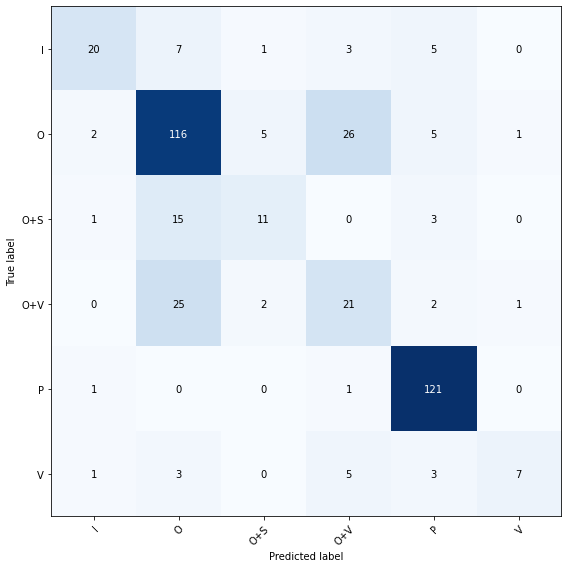

In [34]:
plot_confusion_matrix(onehot.labels, predicted, classes=instrument_filtered, title='musedata_instrument')

#### Normalized confusion matrix

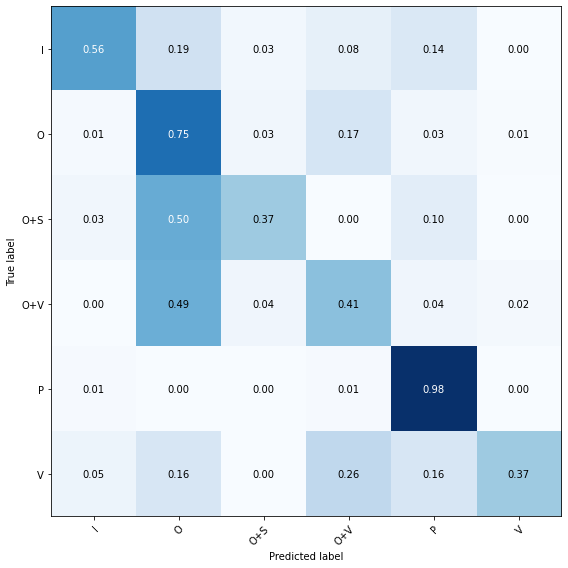

In [35]:
plot_confusion_matrix(onehot.labels, predicted, classes=instrument_filtered, normalize=True, title='musedata_instrument')

### Experiment 4b: Instrument (Split)

In [183]:
data_x_filtered = []
for trainX, trainY, testX, testY in data_x:
    data_filtered, mvt_filtered = clean_and_filter(trainX, trainY.instrument, min_count=7, plotting=False)
    test_idx = testY.instrument.isin(np.unique(mvt_filtered))
    testY = testY[test_idx]
    test_idx = test_idx.to_list()
    testX = [x for i,x in enumerate(testX) if test_idx[i]]
    data_x_filtered.append((data_filtered, mvt_filtered, testX, testY))
    print('Distinct instrument tag considered:', len(np.unique(mvt_filtered)))
    print(len(data_filtered), len(mvt_filtered), len(testX) , len(testY))

Distinct instrument tag considered: 6
272 272 142 142
Distinct instrument tag considered: 6
305 305 109 109
Distinct instrument tag considered: 6
354 354 60 60
Distinct instrument tag considered: 6
377 377 37 37
Distinct instrument tag considered: 6
390 390 24 24
Distinct instrument tag considered: 6
392 392 22 22
Distinct instrument tag considered: 6
403 403 11 11
Distinct instrument tag considered: 6
410 410 4 4
Distinct instrument tag considered: 6
411 411 3 3
Distinct instrument tag considered: 6
412 412 2 2


In [186]:
num_input = data.shape[1]

random_state = 2111
scores_5cs = []

t_stat_s ={}
for j in range(10):
    trainX, trainY, testX, testY = data_x_filtered[j]
    oh = OneHotEncoder(trainY)
    num_output = oh.labels.shape[1]

    neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose=0)
    

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY = oh.encoder.transform(testY.instrument.tolist()) 
    accuracy = neural_network.score(testX, testY, verbose=0)

    scores_5cs.append(accuracy)

print(scores_5cs)
m = np.mean(scores_5cs)
s = np.std(scores_5cs)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.6690141, 0.6880734, 0.41666666, 0.4054054, 0.5, 0.45454547, 0.72727275, 0.5, 0.0, 0.5]
Accuracy: 0.486 (0.195)


Export the results for publication

In [48]:
res = pd.DataFrame.from_dict([{
    'name': 'genre',
    'score': scores_genre
  },{ 
    'name': 'composer',
    'score': scores_composer
  },{
    'name': 'mvt',
    'score': scores_mvt
  },{
    'name': 'instrument',
    'score': scores_instrument
}])
res

,name,score
0,genre,0.712526
1,composer,0.903964
2,mvt,0.683155
3,instrument,0.651394


In [37]:
res.to_latex('output/musedata.classification.latex',index=False)

# 2D Visualisation with TSNE

Picture saved at ./img/tsne-musedata-genre.pdf


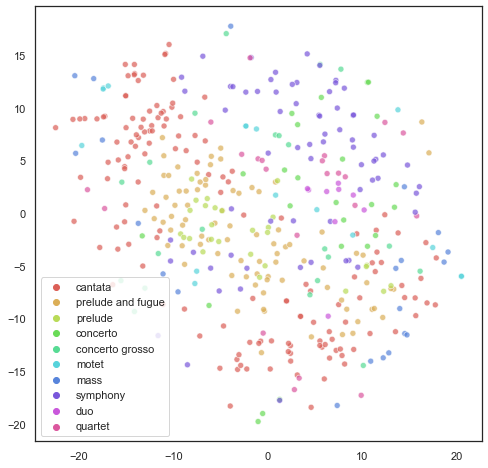

In [38]:
from utils import plot
plot(data, labels=df.genre.tolist(), output='./img/tsne-musedata-genre.pdf')

Picture saved at ./img/tsne-musedata-composer.pdf


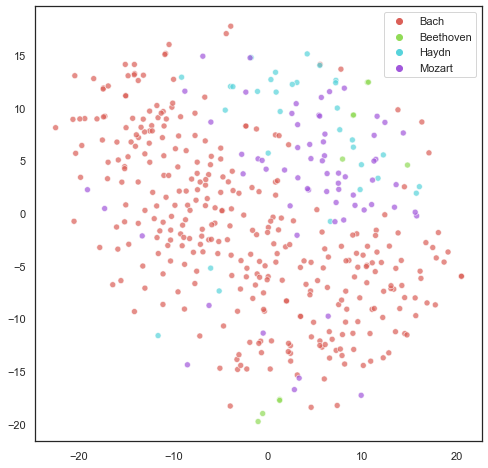

In [39]:
plot(data, labels=df.composer.tolist(), output='./img/tsne-musedata-composer.pdf')

Picture saved at ./img/tsne-musedata-mvt.pdf


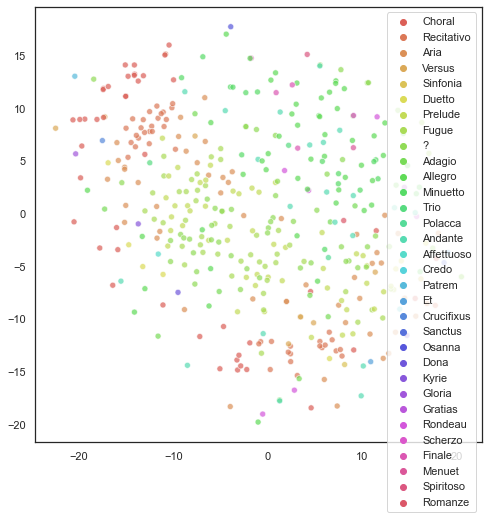

In [40]:
plot(data, labels=df.mvt.tolist(), output='./img/tsne-musedata-mvt.pdf')

Picture saved at ./img/tsne-musedata-instrument.pdf


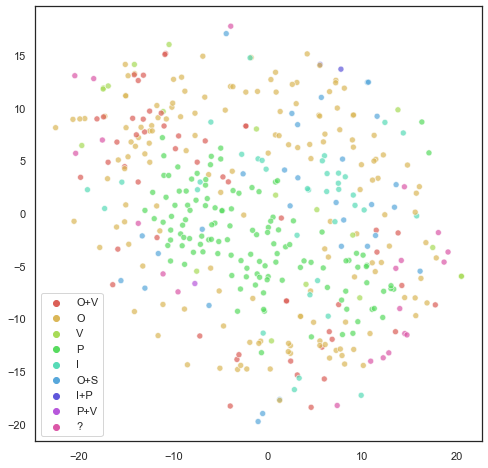

In [41]:
plot(data, labels=df.instrument.tolist(), output='./img/tsne-musedata-instrument.pdf')